# Analyzing series with Monsieur Fourier

Given an arbitrary time series of prices or temperatures, for example, how can we conjure up a function that approximates that data. (In other words, how do we fit an accurate curve to some given x,y data?) The reason we want this function is so we can forecast prices or temperature in the future. To get an accurate approximation, it's helpful to decompose the timeseries, or "signal", into its constituent components:

$signal = average + trend + seasonality + noise$

The seasonality or cyclic component(s) are what we care about here; the other pieces are easy to deal with. We are rephrasing the question in terms of finding the frequency with which prices or temperatures recur.  For example, given New York temperature data the question would be how often the temperature cycles. We might see two cycles, one for the daily temperature rise and fall and a more gradual one as the temperature rises and falls through the seasons. 

One cycle is midnight to midnight and the other is, say, January 1 to January 1. The difference between the cycles is with how fast they cycle and the magnitude the cycle contributes to the overall temperature. The daily temperature fluctuations will most likely be less extreme than the difference between January and August, unless you are lucky enough to live in Hawaii.

What exactly is a cycle? In terms of time, cycles are the hours in a day or the months in the year etc. Graphically we can choose anything that repeats. For example, here are two cycles of a sawtooth:

<img src="sawtooth.png" style="width:20%">

The discontinuities, the pointy parts, cause all sorts of problems mathematically so we want a smoother function. That's where the sine wave comes in. Here are two cycles of a sine wave:

<img src="sine.png" style="width:20%">

We can imagine the temperature gradually rising and falling like a sine wave. If that's the case, then all we have to do is figure out how big the temperature fluctuation is and we can reproduce daily temperature fluctuation (ignoring seasonal trends, of course) pretty accurately. 

Just as a signal or time series has trend and noise components, we can further break down the seasonality into the summation of one or more sinewaves.  Instead of taking a real signal and trying to pull apart its cyclic components, let's start with the reverse and see what happens when we add a bunch of sine waves together. We're going to need some Python packages so let's get those out of the way:

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

## "Send me a sine!"

To draw a curve, we need X coordinates and Y coordinates. In this case, the X coordinates are fixed intervals of time in some units such as hours or days. The Y coordinates result from plugging each x-coordinate into a sine wave function. The nature of the sine wave function is determined by its amplitude (a scaling factor) and the frequency with which the sinewave repeats. The frequency is one over the number of time units to repeat. If we choose hours as our time unit than the frequency is 1/24, one complete cycle in 24 hours.

In [68]:
def sinewave(x,freq=1.0,amp=1.0):
    """
    Return y value from sine wave for x where wave is parameterized
    by the amplitude and frequency in cycles per unit time.  If you
    choose hours as your unit of time, a freq of 1.0 will generate
    a sinewave that begins at x==0 and repeats at x==1. If you choose
    days as your unit of time, then freq=1.0 means that the sinewave
    repeats once per day. The sine wave is simply scaled by the amplitude.
    """
    return amp * np.sin(2 * np.pi * freq * x)

Here is a sine wave that repeats once every 24 hours and has amplitude 1.0:

Text(0,0.5,'sine amplitude')

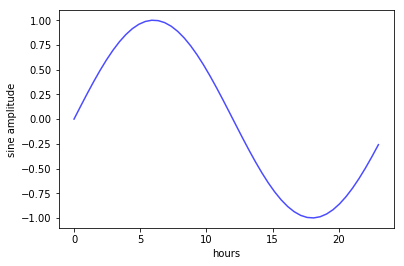

In [72]:
x = np.linspace(0,23,24*2) # hours 0 to 23 and give me 2 data point per hour
f = 1/24 # 1 cycle per 24 hours
plt.plot(x,sinewave(x,f), alpha=0.7, color='blue')
plt.xlabel('hours')
plt.ylabel('sine amplitude')

Changing the amplitude is nothing but change the Y scale:

Text(0,0.5,'sine amplitude')

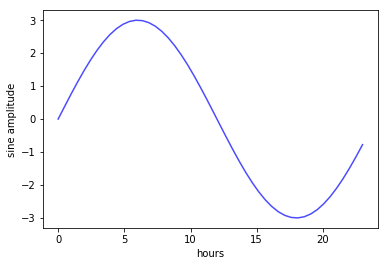

In [115]:
x = np.linspace(0,23,24*2) # hours 0 to 23 and give me 2 data point per hour
a = 3.0
f = 1/24 # 1 cycle per 24 hours
plt.plot(x,sinewave(x,f,a), alpha=0.7, color='blue')
plt.xlabel('hours')
plt.ylabel('sine amplitude')

Changing the frequency however gives us a very different graph. If we want two cycles per 24 hours, we change the frequency to 2/24:

Text(14,0.15,'start')

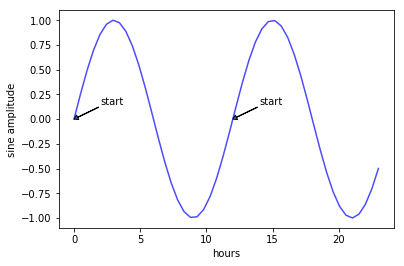

In [116]:
x = np.linspace(0,23,24*2) # hours 0 to 23 and give me 2 data point per hour
f = 2/24 # 2 cycles per 24 hours
plt.plot(x,sinewave(x,f), alpha=0.7, color='blue')
plt.xlabel('hours')
plt.ylabel('sine amplitude')
plt.annotate('start',xy=(0,0),xytext=(2,.15),
             arrowprops=dict(width=0.3,headlength=4,headwidth=5.0))
plt.annotate('start',xy=(12,0),xytext=(14,.15),
             arrowprops=dict(width=0.3,headlength=4,headwidth=5.0))

We can also extend the graph in time to multiple days if we like without changing the sine wave function. The sine wave function is a periodic function that will return a value for any x, no matter how big.

Text(50,0.15,'start')

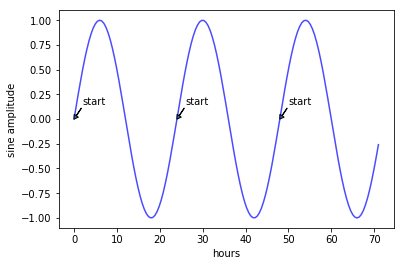

In [121]:
x = np.linspace(0,3*24-1,24*2*3) # 3 days and give me 2 data point per hour
f = 1/24 # 1 cycle per 24 hours
plt.plot(x,sinewave(x,f), alpha=0.7, color='blue')
plt.xlabel('hours')
plt.ylabel('sine amplitude')
plt.annotate('start',xy=(0,0),xytext=(2,.15),
             arrowprops=dict(width=0.3,headlength=4,headwidth=5.0))
plt.annotate('start',xy=(24,0),xytext=(26,.15),
             arrowprops=dict(width=0.3,headlength=4,headwidth=5.0))
plt.annotate('start',xy=(48,0),xytext=(50,.15),
             arrowprops=dict(width=0.3,headlength=4,headwidth=5.0))

## Adding sine waves

A single sine wave isn't particularly interesting but it's important to get the units of the X and Y coordinates exactly right. Now that we know how frequency and amplitude affects those, let's figure out what happens when we add sine waves together.  Here are two signals, one with frequency of one cycle per 24 hours and another with a frequency of 24 repetitions per 24 hours (1 per hour):

Text(0,0.5,'sine amplitude 1')

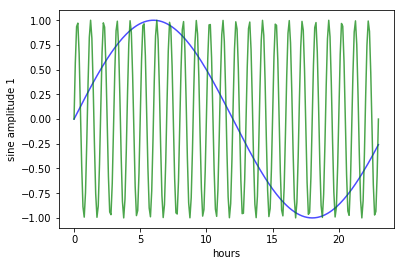

In [150]:
x = np.linspace(0,23,24*10) # hours 0 to 23, 10 data points per hour
plt.plot(x,sinewave(x,1/24), alpha=.7, color='blue')
plt.plot(x,sinewave(x,24/24), alpha=.7, color='green')
plt.xlabel('hours')
plt.ylabel('sine amplitude 1')

Now, let's add the two signals together:

Text(0,0.5,'sine amplitude 1')

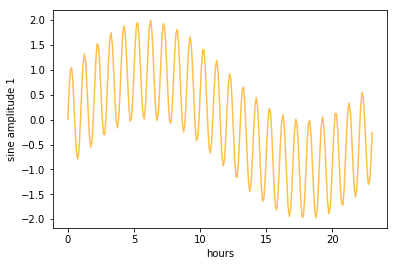

In [151]:
x = np.linspace(0,23,24*10) # hours 0 to 23, 10 data points per hour
plt.plot(x,sinewave(x,1/24) + sinewave(x,24/24), alpha=.7, color='orange')
plt.xlabel('hours')
plt.ylabel('sine amplitude 1')

We can see that there is an overall trend during the day and then lots of bouncing up and down once an hour.  Notice that the amplitude is now in the range of -2 to 2 not -1 to 1 because we've added to sine waves whose amplitudes are in the range -1 to 1.

**The punchline here is that, in theory, we can approximate just about any signal by adding up a bunch of sine waves.**

## Decomposing signals into sine waves

Okay, now let's go the other direction and figure out which sine waves are lurking inside a signal.  The goal of this analysis is a list of sine waves that, when added together, give us back the original signal.  For each sinewave, we need to discover it's amplitude and frequency as we seen, but there's one other thing we need: it's *phase*. The phase is really just how much to shift the starting point of the cycle. For example we've always started sine waves at zero, but what if we want to start at hour 2 or day 18, for example? So a sine wave is completely described by its amplitude, its frequency, and its offset (phase). Here is our original sine wave with two shifted versions of it:

Text(0,0.5,'sine amplitude')

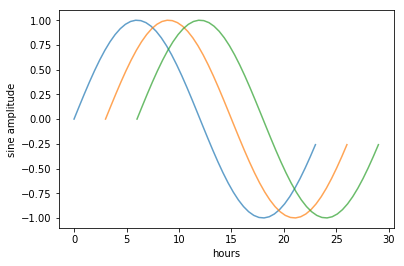

In [164]:
x = np.linspace(0,23,24*2) # hours 0 to 23 and give me 2 data point per hour
f = 1/24 # 1 cycle per 24 hours
plt.plot(x+0,sinewave(x,f), alpha=0.7)
plt.plot(x+3,sinewave(x,f), alpha=0.7) # shift start by 3 hours
plt.plot(x+6,sinewave(x,f), alpha=0.7) # shift 6 hours
plt.xlabel('hours')
plt.ylabel('sine amplitude')

If you remember from high school trigonometry, a cosine is a sine wave shifted by 90° or $\pi \over 2$ radians.

In [152]:
def cosinewave(x,freq=1.0,amp=1.0):
    return amp * np.cos(2 * np.pi * freq * x)

Text(0,0.5,'sine amplitude')

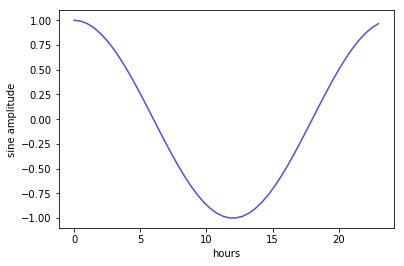

In [153]:
x = np.linspace(0,23,24*2) # hours 0 to 23 and give me 2 data point per hour
f = 1/24 # 1 cycle per 24 hours
plt.plot(x,cosinewave(x,f), alpha=0.7, color='blue')
plt.xlabel('hours')
plt.ylabel('sine amplitude')